## Introduction to Deep Learning 
# Training DNN with Keras
### boston house price regression example
* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
* https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [1125]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import utils_plot as uplot
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss

%matplotlib inline  

## Utilities

In [1126]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [1127]:
def drow_history_list(history_list, history_names=None,  metric=None):
    
    if metric is None:
        metric = 'loss'
        
    leg = []
    if history_names is not None:
        for n in history_names:
            leg.append('train ' + n)
            leg.append('test ' + n)
    else:
        for n in range(len(history_list)):
            leg.append('train ' + str(n))
            leg.append('test ' + str(n))
            
    for hist in history_list:
        
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+ metric], '--', linewidth=2)
        
        
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(leg, loc='best')
    plt.show()  

In [1128]:
def drow_history(history, metric, i_start=0):
    if metric is None:
        metric = 'loss'
    plt.plot(history.history[metric][i_start:])
    plt.plot(history.history['val_'+ metric][i_start:])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [1129]:
import keras
# Keras has many build in data sets
from keras.datasets import mnist
# Sequential is the basic feed forward neural network (FFN)
from keras.models import Sequential
# Dense is fully connected layer
# Dropout is a "noising" layer, to prevent over feet.
from keras.layers import Dense, Dropout
# Read about optimizers in keras documentation
from keras.optimizers import RMSprop
from keras import optimizers

## Read data and Pre-process

In [1130]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

Data fields
* Here's a brief version of what you'll find in the data description file.

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

In [1131]:
train = pd.read_csv('boston_train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1132]:
test = pd.read_csv('boston_test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Combine train and test data to process them together

In [1133]:
target = train.SalePrice
train.drop(['SalePrice'],axis = 1 , inplace = True)

combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

In [1134]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [1135]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [1136]:
num_cols_train = get_cols_with_no_nans(train , 'num')
cat_cols_train = get_cols_with_no_nans(train , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols_train))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols_train))

Number of numerical columns with no nan values : 34
Number of nun-numerical columns with no nan values : 27


In [1137]:
num_cols_combined = get_cols_with_no_nans(combined , 'num')
cat_cols_combined = get_cols_with_no_nans(combined , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols_combined))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols_combined))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


In [1138]:
num_cols_test = get_cols_with_no_nans(test , 'num')
cat_cols_test = get_cols_with_no_nans(test , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols_test))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols_test))

Number of numerical columns with no nan values : 26
Number of nun-numerical columns with no nan values : 21


In [1139]:
dif =list(set(num_cols_train)-set(num_cols_test))

In [1140]:
train[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
BsmtFinSF1      1460 non-null int64
GarageCars      1460 non-null int64
GarageArea      1460 non-null int64
BsmtFullBath    1460 non-null int64
BsmtUnfSF       1460 non-null int64
BsmtFinSF2      1460 non-null int64
BsmtHalfBath    1460 non-null int64
TotalBsmtSF     1460 non-null int64
dtypes: int64(8)
memory usage: 91.3 KB


In [1141]:
test[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
BsmtFinSF1      1458 non-null float64
GarageCars      1458 non-null float64
GarageArea      1458 non-null float64
BsmtFullBath    1457 non-null float64
BsmtUnfSF       1458 non-null float64
BsmtFinSF2      1458 non-null float64
BsmtHalfBath    1457 non-null float64
TotalBsmtSF     1458 non-null float64
dtypes: float64(8)
memory usage: 91.3 KB


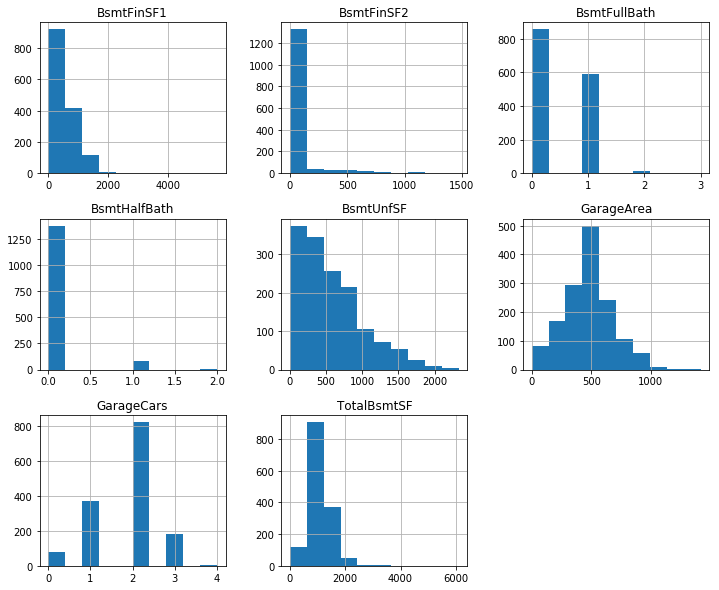

In [1142]:
train[dif].hist(figsize = (12,10))
plt.show()

In [1143]:
dif

['BsmtFinSF1',
 'GarageCars',
 'GarageArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'TotalBsmtSF']

In [1144]:
fil0 = ['BsmtFinSF1',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtHalfBath']
test[fil0] = test[fil0].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(2.)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(train['TotalBsmtSF'].median())

#### Check null in categorical columns

In [1145]:
dif =list(set(cat_cols_train)-set(cat_cols_test))

In [1146]:
train.shape,test.shape

((1460, 80), (1459, 80))

In [1147]:
train[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
KitchenQual    1460 non-null object
Exterior2nd    1460 non-null object
Exterior1st    1460 non-null object
Functional     1460 non-null object
Utilities      1460 non-null object
MSZoning       1460 non-null object
SaleType       1460 non-null object
dtypes: object(7)
memory usage: 79.9+ KB


In [1148]:
test[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
KitchenQual    1458 non-null object
Exterior2nd    1458 non-null object
Exterior1st    1458 non-null object
Functional     1457 non-null object
Utilities      1457 non-null object
MSZoning       1455 non-null object
SaleType       1458 non-null object
dtypes: object(7)
memory usage: 79.9+ KB


In [1149]:
for col in dif:
    print(col)
    test[col] = test[col].fillna(value=str(train[col].mode()[0]))

KitchenQual
Exterior2nd
Exterior1st
Functional
Utilities
MSZoning
SaleType


In [1150]:
test[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
KitchenQual    1459 non-null object
Exterior2nd    1459 non-null object
Exterior1st    1459 non-null object
Functional     1459 non-null object
Utilities      1459 non-null object
MSZoning       1459 non-null object
SaleType       1459 non-null object
dtypes: object(7)
memory usage: 79.9+ KB


In [1151]:
test.KitchenQual.value_counts()

TA    758
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [1152]:
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

In [1153]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 32
Number of nun-numerical columns with no nan values : 27


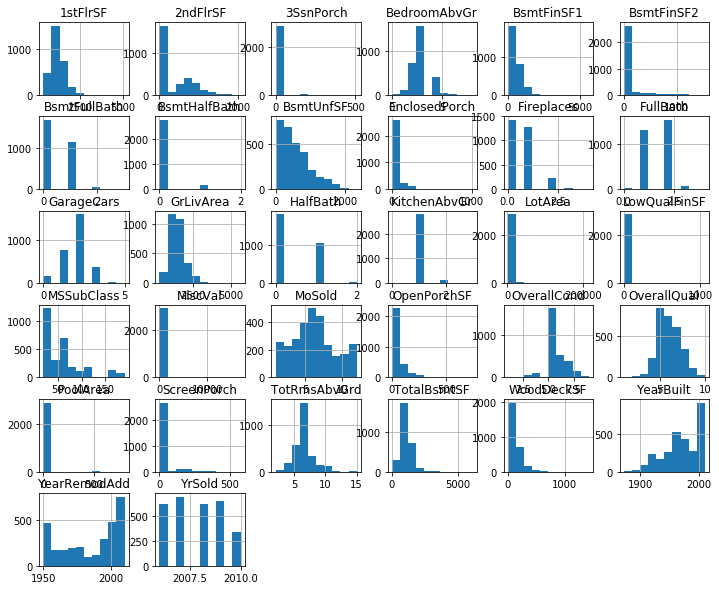

In [1154]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

## Manage categorial variable

In [1155]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 59 columns before encoding categorical features
There are 214 columns after encoding categorical features


In [1156]:
## Split back
train = combined[:1460]
test = combined[1460:]

### Normalize

## Regression Loss functions
### The mean absolute percentage error (MAPE)
MAPE, also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a Loss function for regression problems in Machine Learning. It usually expresses accuracy as a percentage, and is defined by the formula:

$${\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,} {\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,}$$
where $A_t$ is the actual value and $F_t$ is the forecast value. The difference between $A_t$  and $F_t$ is divided by the actual value $A_t$  again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

* https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

### mean_absolute_error
### mean_squared_error
### mean_squared_logarithmic_error

## Build Keras model - train and predict

In [1158]:
def get_model():
    
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    
    return NN_model
np.random.seed(1235)
NN_model = get_model()

# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 128)               27520     
_________________________________________________________________
dense_113 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_114 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_115 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 257       
Total params: 192,385
Trainable params: 192,385
Non-trainable params: 0
_________________________________________________________________


### Monitor Training
* EarlyStopping
* Save best models
* ReduceLROnPlateau

In [1159]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 32

checkpoint = ModelCheckpoint('best_model_e200_b32_oAdam.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1, mode='auto')

history = NN_model.fit(train, target,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early],
                    validation_split=0.3)

Train on 1021 samples, validate on 439 samples
Epoch 1/200
1021/1021 [==============================] - 1s 1ms/step - loss: 21.9235 - mean_absolute_error: 176577.3164 - val_loss: 5.0111 - val_mean_absolute_error: 159824.3666

Epoch 00001: val_loss improved from inf to 5.01107, saving model to best_model_e200_b32_oAdam.h5
Epoch 2/200
1021/1021 [==============================] - 0s 219us/step - loss: 1.5660 - mean_absolute_error: 112763.2777 - val_loss: 0.1239 - val_mean_absolute_error: 49413.2559

Epoch 00002: val_loss improved from 5.01107 to 0.12388, saving model to best_model_e200_b32_oAdam.h5
Epoch 3/200
1021/1021 [==============================] - 0s 214us/step - loss: 0.1372 - mean_absolute_error: 57934.6336 - val_loss: 0.1151 - val_mean_absolute_error: 48043.6179

Epoch 00003: val_loss improved from 0.12388 to 0.11505, saving model to best_model_e200_b32_oAdam.h5
Epoch 4/200
1021/1021 [==============================] - 0s 223us/step - loss: 0.1217 - mean_absolute_error: 53094.036

1021/1021 [==============================] - 0s 204us/step - loss: 0.0432 - mean_absolute_error: 28247.6084 - val_loss: 0.0498 - val_mean_absolute_error: 29634.1146

Epoch 00032: val_loss did not improve from 0.04945
Epoch 00032: early stopping


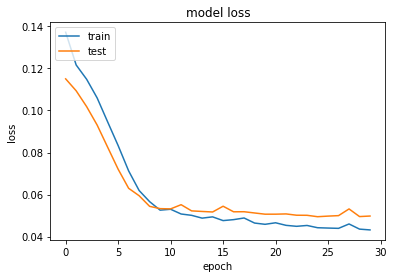

In [1160]:
drow_history(history, 'loss', 2)

In [1161]:
#### Load the best model
NN_model.load_weights('best_model_e200_b32_oAdam.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [1162]:
score=NN_model.evaluate(train, target)

1460/1460 [==============================] - 1s 619us/step


In [1093]:
score

[0.043381078704579239, 27991.362264554795]

In [1094]:
def make_submission(prediction, sub_name):
    my_submission = pd.DataFrame({'Id':pd.read_csv('boston_test.csv').Id,'SalePrice':prediction})
    my_submission.to_csv('{}.csv'.format(sub_name),index=False)
    print('A submission file has been made')

predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_oAdam.csv')

A submission file has been made


kaggle result: 0.22215
************************************************************

## Improvments

Split the data, for better model comparison

In [1164]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=.3, 
                                                    random_state=42)
X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
135,20,10400,7,6,1970,1970,0.0,0.0,1304.0,1304.0,...,0,0,0,1,0,0,0,0,1,0
1452,180,3675,5,5,2005,2005,547.0,0.0,0.0,547.0,...,0,0,0,1,0,0,0,0,1,0
762,60,8640,7,5,2009,2009,24.0,0.0,732.0,756.0,...,0,0,0,0,0,0,0,0,1,0
932,20,11670,9,5,2006,2006,0.0,0.0,1905.0,1905.0,...,0,0,0,1,0,0,0,0,1,0
435,60,10667,7,6,1996,1996,385.0,344.0,70.0,799.0,...,1,0,0,0,0,0,0,0,1,0


In [1165]:
np.random.seed(1235)
NN_model = get_model()

# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [1166]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 32

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001, verbose=1)

checkpoint = ModelCheckpoint('best_model_e200_b32_oadam_lr.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=1, mode='auto')

history = NN_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early, reduce_lr],
                    validation_data=(X_test, y_test))

Train on 1022 samples, validate on 438 samples
Epoch 1/200
1022/1022 [==============================] - 1s 1ms/step - loss: 20.9972 - mean_absolute_error: 175309.5531 - val_loss: 4.2748 - val_mean_absolute_error: 157200.5808

Epoch 00001: val_loss improved from inf to 4.27481, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 2/200
1022/1022 [==============================] - 0s 221us/step - loss: 1.2773 - mean_absolute_error: 106735.9286 - val_loss: 0.1352 - val_mean_absolute_error: 52763.8402

Epoch 00002: val_loss improved from 4.27481 to 0.13517, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 3/200
1022/1022 [==============================] - 0s 236us/step - loss: 0.1355 - mean_absolute_error: 57102.7374 - val_loss: 0.1305 - val_mean_absolute_error: 52513.2714

Epoch 00003: val_loss improved from 0.13517 to 0.13050, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 4/200
1022/1022 [==============================] - 0s 237us/step - loss: 0.1220 - mean_absolute_error: 

1022/1022 [==============================] - 0s 210us/step - loss: 0.0484 - mean_absolute_error: 30042.6423 - val_loss: 0.0441 - val_mean_absolute_error: 28674.8810

Epoch 00031: val_loss improved from 0.04434 to 0.04414, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 32/200
1022/1022 [==============================] - 0s 213us/step - loss: 0.0476 - mean_absolute_error: 29764.4116 - val_loss: 0.0441 - val_mean_absolute_error: 29048.1475

Epoch 00032: val_loss improved from 0.04414 to 0.04407, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 33/200
1022/1022 [==============================] - 0s 221us/step - loss: 0.0474 - mean_absolute_error: 29668.4182 - val_loss: 0.0442 - val_mean_absolute_error: 28415.7895

Epoch 00033: val_loss did not improve from 0.04407
Epoch 34/200
1022/1022 [==============================] - 0s 182us/step - loss: 0.0474 - mean_absolute_error: 29661.2116 - val_loss: 0.0448 - val_mean_absolute_error: 29879.8604

Epoch 00034: val_loss did not improve 

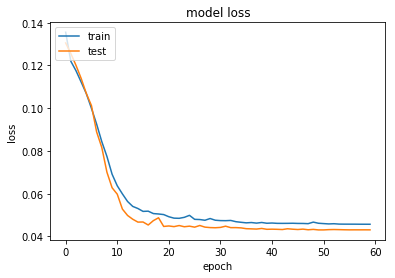

In [1167]:
drow_history(history, 'loss', 2)

In [1168]:
#### Load the best model
NN_model.load_weights('best_model_e200_b32_oadam_lr.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [1169]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 1s 2ms/step


[0.043052575546720803, 28143.852151113013]

In [1170]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 74us/step


[0.045088291106975244, 28629.388907320204]

In [1122]:
predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_oadam_lr')

A submission file has been made


* kaggle result  0.22401
**********************************************************************************

In [1216]:
np.random.seed(1235)
    
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',
                       input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    

# mean_squared_logarithmic_error
# mean_absolute_error
# mean_squared_error


# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop', 
                 metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_167 (Dense)            (None, 128)               27520     
_________________________________________________________________
dense_168 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_169 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_170 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 513       
Total params: 619,393
Trainable params: 619,393
Non-trainable params: 0
_________________________________________________________________


In [1217]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 32

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

checkpoint = ModelCheckpoint('best_model_e200_b32_rmsprop_net_128_512_512_512.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=1, mode='auto')

history = NN_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early, reduce_lr],
                    validation_data=(X_test, y_test))

Train on 1022 samples, validate on 438 samples
Epoch 1/200
1022/1022 [==============================] - 2s 2ms/step - loss: 7.6672 - mean_absolute_error: 110256.8168 - val_loss: 0.1582 - val_mean_absolute_error: 57675.4518

Epoch 00001: val_loss improved from inf to 0.15821, saving model to best_model_e200_b32_oadam_lr_norm.h5
Epoch 2/200
1022/1022 [==============================] - 1s 639us/step - loss: 0.1379 - mean_absolute_error: 56903.3865 - val_loss: 0.1253 - val_mean_absolute_error: 50713.5728

Epoch 00002: val_loss improved from 0.15821 to 0.12531, saving model to best_model_e200_b32_oadam_lr_norm.h5
Epoch 3/200
1022/1022 [==============================] - 1s 614us/step - loss: 0.1020 - mean_absolute_error: 47661.9225 - val_loss: 0.0811 - val_mean_absolute_error: 39787.1975

Epoch 00003: val_loss improved from 0.12531 to 0.08113, saving model to best_model_e200_b32_oadam_lr_norm.h5
Epoch 4/200
1022/1022 [==============================] - 1s 625us/step - loss: 0.0891 - mean_abso

1022/1022 [==============================] - 1s 621us/step - loss: 0.0461 - mean_absolute_error: 28989.0661 - val_loss: 0.0397 - val_mean_absolute_error: 26933.2527

Epoch 00032: val_loss improved from 0.03990 to 0.03969, saving model to best_model_e200_b32_oadam_lr_norm.h5
Epoch 33/200
1022/1022 [==============================] - 1s 593us/step - loss: 0.0448 - mean_absolute_error: 28476.3680 - val_loss: 0.0451 - val_mean_absolute_error: 30580.7596

Epoch 00033: val_loss did not improve from 0.03969
Epoch 34/200
1022/1022 [==============================] - 1s 583us/step - loss: 0.0455 - mean_absolute_error: 28774.3851 - val_loss: 0.0453 - val_mean_absolute_error: 30901.6008

Epoch 00034: val_loss did not improve from 0.03969
Epoch 35/200
1022/1022 [==============================] - 1s 617us/step - loss: 0.0446 - mean_absolute_error: 28608.8943 - val_loss: 0.0447 - val_mean_absolute_error: 30656.8494

Epoch 00035: val_loss did not improve from 0.03969
Epoch 36/200
1022/1022 [===========

1022/1022 [==============================] - 1s 642us/step - loss: 0.0400 - mean_absolute_error: 26556.8622 - val_loss: 0.0381 - val_mean_absolute_error: 26294.4643

Epoch 00064: val_loss did not improve from 0.03773
Epoch 65/200
1022/1022 [==============================] - 1s 677us/step - loss: 0.0411 - mean_absolute_error: 27001.3110 - val_loss: 0.0379 - val_mean_absolute_error: 25310.2603

Epoch 00065: val_loss did not improve from 0.03773

Epoch 00065: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 66/200
1022/1022 [==============================] - 1s 638us/step - loss: 0.0401 - mean_absolute_error: 26520.5691 - val_loss: 0.0382 - val_mean_absolute_error: 26591.2473

Epoch 00066: val_loss did not improve from 0.03773
Epoch 67/200
1022/1022 [==============================] - 1s 636us/step - loss: 0.0399 - mean_absolute_error: 26612.0063 - val_loss: 0.0376 - val_mean_absolute_error: 25947.0717

Epoch 00067: val_loss improved from 0.03773 to 0.03762, saving m


Epoch 00096: val_loss did not improve from 0.03722
Epoch 97/200
1022/1022 [==============================] - 1s 647us/step - loss: 0.0387 - mean_absolute_error: 26059.9554 - val_loss: 0.0372 - val_mean_absolute_error: 25707.3057

Epoch 00097: val_loss did not improve from 0.03722
Epoch 98/200
1022/1022 [==============================] - 1s 665us/step - loss: 0.0388 - mean_absolute_error: 25929.2015 - val_loss: 0.0374 - val_mean_absolute_error: 25996.6638

Epoch 00098: val_loss did not improve from 0.03722
Epoch 00098: early stopping


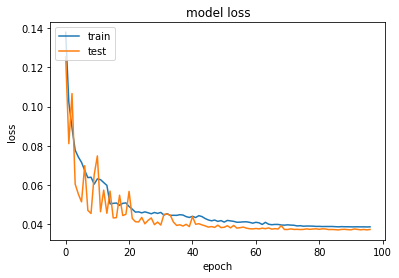

In [1218]:
drow_history(history, 'loss', 1)

In [1219]:
#### Load the best model
NN_model.load_weights('best_model_e200_b32_rmsprop_net_128_512_512_512.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [1220]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 1s 3ms/step


[0.037218259809087946, 25521.182603809932, 0.037218259809087946]

In [1221]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 167us/step


[0.038429679599118562, 25710.836649186644, 0.038429679599118562]

In [1224]:
predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_rmsprop_net_128_512_512_512')

A submission file has been made


* Result 0.20622

******************************************************************

In [ ]:
* Enlarge the first Layer
* Drop the last Layer
* reduce batch size

In [1252]:
np.random.seed(1235)
    
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(264, kernel_initializer='normal',
                       input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))


# mean_squared_logarithmic_error
# mean_absolute_error
# mean_squared_error


# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop', 
                 metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_197 (Dense)            (None, 264)               56760     
_________________________________________________________________
dense_198 (Dense)            (None, 512)               135680    
_________________________________________________________________
dense_199 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_200 (Dense)            (None, 1)                 513       
Total params: 455,609
Trainable params: 455,609
Non-trainable params: 0
_________________________________________________________________


In [1253]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 16

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

checkpoint = ModelCheckpoint('best_model_e200_b16_rmsprop_net_264_512_512.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=1, mode='auto')

history = NN_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early, reduce_lr],
                    validation_data=(X_test, y_test))

Train on 1022 samples, validate on 438 samples
Epoch 1/200
1022/1022 [==============================] - 3s 3ms/step - loss: 2.6437 - mean_absolute_error: 95033.6012 - val_loss: 0.1175 - val_mean_absolute_error: 49800.7000

Epoch 00001: val_loss improved from inf to 0.11753, saving model to best_model_e200_b16_rmspror.h5
Epoch 2/200
1022/1022 [==============================] - 1s 919us/step - loss: 0.0941 - mean_absolute_error: 45259.8647 - val_loss: 0.0818 - val_mean_absolute_error: 41254.7938

Epoch 00002: val_loss improved from 0.11753 to 0.08179, saving model to best_model_e200_b16_rmspror.h5
Epoch 3/200
1022/1022 [==============================] - 1s 910us/step - loss: 0.0751 - mean_absolute_error: 39243.8858 - val_loss: 0.0590 - val_mean_absolute_error: 32959.7120

Epoch 00003: val_loss improved from 0.08179 to 0.05904, saving model to best_model_e200_b16_rmspror.h5
Epoch 4/200
1022/1022 [==============================] - 1s 898us/step - loss: 0.0622 - mean_absolute_error: 34884.4

1022/1022 [==============================] - 1s 861us/step - loss: 0.0420 - mean_absolute_error: 27379.7760 - val_loss: 0.0394 - val_mean_absolute_error: 25745.4651

Epoch 00033: val_loss did not improve from 0.03806
Epoch 34/200
1022/1022 [==============================] - 1s 837us/step - loss: 0.0416 - mean_absolute_error: 27120.3989 - val_loss: 0.0390 - val_mean_absolute_error: 27116.0352

Epoch 00034: val_loss did not improve from 0.03806
Epoch 35/200
1022/1022 [==============================] - 1s 854us/step - loss: 0.0413 - mean_absolute_error: 27363.6005 - val_loss: 0.0459 - val_mean_absolute_error: 30951.6649

Epoch 00035: val_loss did not improve from 0.03806

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 36/200
1022/1022 [==============================] - 1s 866us/step - loss: 0.0394 - mean_absolute_error: 26353.0985 - val_loss: 0.0361 - val_mean_absolute_error: 24800.9470

Epoch 00036: val_loss improved from 0.03806 to 0.03611, saving 

1022/1022 [==============================] - 1s 871us/step - loss: 0.0341 - mean_absolute_error: 24292.9543 - val_loss: 0.0343 - val_mean_absolute_error: 24508.2349

Epoch 00066: val_loss did not improve from 0.03391

Epoch 00066: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 67/200
1022/1022 [==============================] - 1s 835us/step - loss: 0.0337 - mean_absolute_error: 24206.4426 - val_loss: 0.0339 - val_mean_absolute_error: 24118.6050

Epoch 00067: val_loss improved from 0.03391 to 0.03388, saving model to best_model_e200_b16_rmspror.h5
Epoch 68/200
1022/1022 [==============================] - 1s 806us/step - loss: 0.0338 - mean_absolute_error: 24120.9219 - val_loss: 0.0340 - val_mean_absolute_error: 24341.8390

Epoch 00068: val_loss did not improve from 0.03388
Epoch 69/200
1022/1022 [==============================] - 1s 828us/step - loss: 0.0337 - mean_absolute_error: 24176.6283 - val_loss: 0.0339 - val_mean_absolute_error: 24199.9455

Epoch 00069

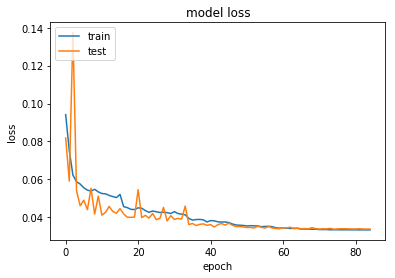

In [1254]:
drow_history(history, 'loss', 1)

In [1255]:
#### Load the best model
NN_model.load_weights('best_model_e200_b16_rmsprop_net_264_512_512'.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [1256]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 2s 4ms/step


[0.0336962574284915, 24005.091814711759]

In [1235]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 1s 3ms/step


[0.0379358490240084, 25851.205479452055]

In [1257]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 166us/step


[0.033474536219688308, 23910.426209332192]

In [1236]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 149us/step


[0.039954438672898565, 26339.635156249999]

In [1258]:
y_test_pred = NN_model.predict(X_test)
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(y_test, y_test_pred)

0.033696257228431087

In [1259]:
predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_rmsprop_net_264_512_512')

A submission file has been made


In [ ]:
* result 0.19681